# Threat Scoring and Risk Classification

## Project: PERIL - Public Event Risk Intelligence London

### Objective
This notebook develops a threat scoring algorithm for London transport infrastructure by combining:
- **Crowd density metrics** (from TfL traffic data)
- **Infrastructure criticality** (station importance, connectivity)
- **Vulnerability attributes** (accessibility, structural factors)

### Methodology
Following evidence-based threat assessment principles:
1. Normalize traffic data to create crowd density scores
2. Apply weighted scoring based on multiple risk factors
3. Classify stations into threat levels (High/Medium/Low)
4. Identify geographic clustering of high-risk areas

### Threat Assessment Framework
Based on counter-terrorism guidance, we assess:
- **Impact potential**: Crowd size and density
- **Symbolic value**: Major hubs vs local stations
- **Accessibility**: Open access vs controlled entry
- **Recovery difficulty**: Network criticality

## 1. Setup and Load Data

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Define data directory
DATA_DIR = Path('../data/tfl')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [4]:
# Load 2024 annualized data
file_path = DATA_DIR / 'AC2024_AnnualisedEntryExit_CrowdingPublic__AC24_v17.2_E9_annualised.csv'
df_2024 = pd.read_csv(file_path, skiprows=6)

# Print available columns for debugging
print("Available columns in 2024 data:", list(df_2024.columns))

# List of possible annual entry/exit column names
annual_col_candidates = [
    'Annualised', 'Annual Entry/Exit', 'En/Ex', 'Annual_EntryExit', 'Annual Entry Exit', 'Annual Entry', 'Annual Exit',
    'Annualised Entry/Exit', 'Annualised Entry Exit', 'Annualised Entry', 'Annualised Exit'
]

# Find the first matching column
annual_col = None
for col in annual_col_candidates:
    if col in df_2024.columns:
        annual_col = col
        break
if annual_col is None:
    raise KeyError(f"None of the expected annual entry/exit columns found. Columns present: {list(df_2024.columns)}")

# Clean and structure the data
col_map = {
    'Mode': 'Mode',
    'MASC': 'Station_Code',
    'Station': 'Station_Name',
    'Coverage': 'Coverage',
    'Source': 'Source',
    annual_col: 'Annual_EntryExit'
}

missing_cols = [k for k in col_map if k not in df_2024.columns]
if missing_cols:
    raise KeyError(f"Missing expected columns: {missing_cols}. Columns present: {list(df_2024.columns)}")

df_stations = df_2024[list(col_map.keys())].copy()
df_stations.columns = list(col_map.values())
df_stations['Annual_EntryExit'] = pd.to_numeric(df_stations['Annual_EntryExit'], errors='coerce')
df_stations = df_stations.dropna(subset=['Annual_EntryExit'])

print(f"Loaded data for {len(df_stations)} stations")
print(f"Total annual traffic: {df_stations['Annual_EntryExit'].sum():,.0f}")

Available columns in 2024 data: ['Mode', 'MNLC', 'MASC', 'Station', 'Coverage', 'Source', 'Entries', 'Entries.1', 'Entries.2', 'Entries.3', 'Entries.4', 'Exits', 'Exits.1', 'Exits.2', 'Exits.3', 'Exits.4', 'En/Ex', 'En/Ex.1', 'En/Ex.2']
Loaded data for 429 stations
Total annual traffic: 61,273,655


## 2. Create Crowd Density Score

Normalize traffic data to a 0-100 scale to quantify crowd density risk.

In [5]:
# Calculate percentile-based crowd density score (0-100)
df_stations['Crowd_Density_Score'] = stats.rankdata(df_stations['Annual_EntryExit'], method='average') / len(df_stations) * 100

# Alternative: Min-Max normalization
min_traffic = df_stations['Annual_EntryExit'].min()
max_traffic = df_stations['Annual_EntryExit'].max()
df_stations['Traffic_Score_MinMax'] = ((df_stations['Annual_EntryExit'] - min_traffic) / (max_traffic - min_traffic)) * 100

print("Crowd Density Scoring Complete")
print(f"Score range: {df_stations['Crowd_Density_Score'].min():.1f} - {df_stations['Crowd_Density_Score'].max():.1f}")
print(f"\nTop 10 stations by crowd density:")
print(df_stations.nlargest(10, 'Crowd_Density_Score')[['Station_Name', 'Annual_EntryExit', 'Crowd_Density_Score']])

Crowd Density Scoring Complete
Score range: 0.2 - 100.0

Top 10 stations by crowd density:
                 Station_Name  Annual_EntryExit  Crowd_Density_Score
246               Waterloo LU      1.589208e+06           100.000000
129  King's Cross St. Pancras      1.583739e+06            99.766900
241               Victoria LU      1.287230e+06            99.533800
228      Tottenham Court Road      1.274380e+06            99.300699
139       Liverpool Street LU      1.256737e+06            99.067599
140          London Bridge LU      1.188796e+06            98.834499
172            Paddington TfL      1.157603e+06            98.601399
220                 Stratford      1.144202e+06            98.368298
171             Oxford Circus      1.091979e+06            98.135198
79                 Farringdon      8.472979e+05            97.902098


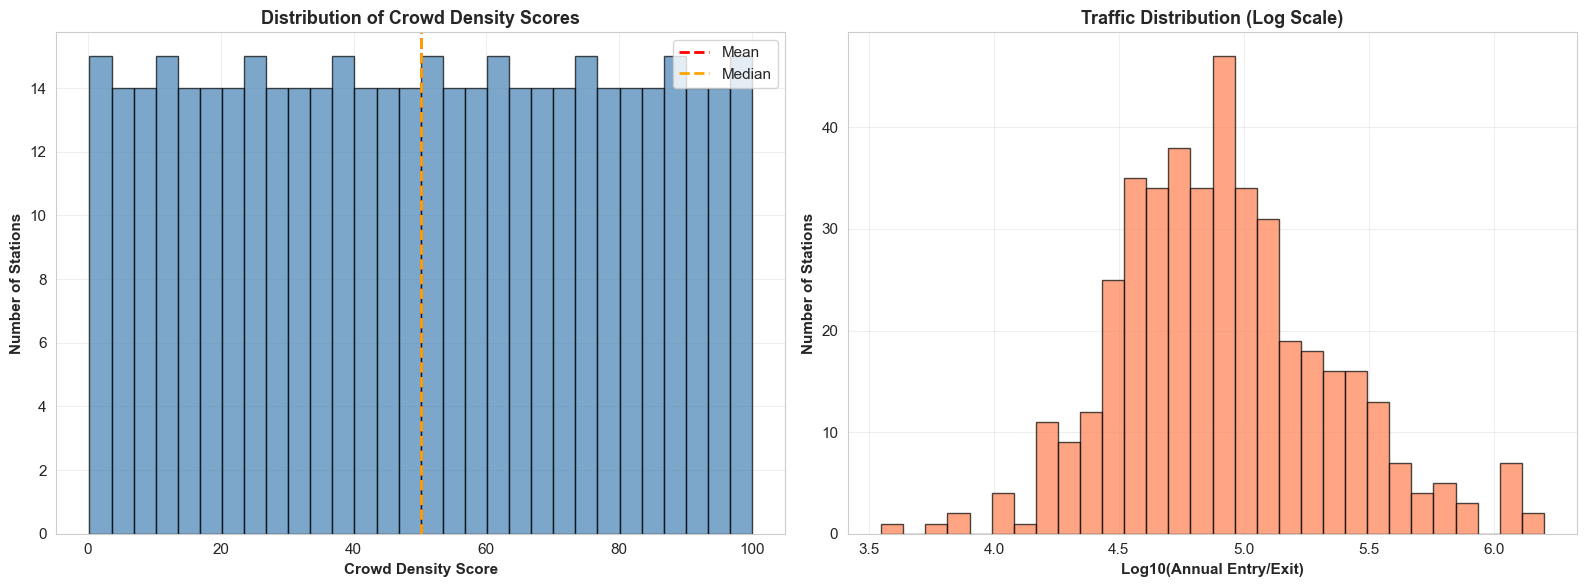

In [6]:
# Visualize crowd density distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of crowd density scores
axes[0].hist(df_stations['Crowd_Density_Score'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(df_stations['Crowd_Density_Score'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(df_stations['Crowd_Density_Score'].median(), color='orange', linestyle='--', linewidth=2, label='Median')
axes[0].set_xlabel('Crowd Density Score', fontweight='bold')
axes[0].set_ylabel('Number of Stations', fontweight='bold')
axes[0].set_title('Distribution of Crowd Density Scores', fontweight='bold', fontsize=13)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Log-scale traffic distribution
axes[1].hist(np.log10(df_stations['Annual_EntryExit']), bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Log10(Annual Entry/Exit)', fontweight='bold')
axes[1].set_ylabel('Number of Stations', fontweight='bold')
axes[1].set_title('Traffic Distribution (Log Scale)', fontweight='bold', fontsize=13)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Infrastructure Criticality Score

Major interchange stations and network hubs have higher symbolic value and operational criticality.

In [7]:
# Define major interchange and symbolic stations (based on TfL network knowledge)
major_interchanges = [
    'Bank and Monument', 'King\'s Cross St. Pancras', 'Waterloo', 'Victoria', 'Liverpool Street',
    'Oxford Circus', 'London Bridge', 'Stratford', 'Paddington', 'Bond Street',
    'Baker Street', 'Euston', 'Canary Wharf', 'Westminster', 'Green Park',
    'Clapham Junction', 'Vauxhall', 'Finsbury Park', 'Tottenham Court Road', 'Leicester Square'
]

# Create criticality score
df_stations['Is_Major_Hub'] = df_stations['Station_Name'].isin(major_interchanges).astype(int)
df_stations['Infrastructure_Score'] = df_stations['Is_Major_Hub'] * 30  # Bonus points for major hubs

print(f"Major hubs identified: {df_stations['Is_Major_Hub'].sum()}")
print(f"\nMajor hubs in dataset:")
print(df_stations[df_stations['Is_Major_Hub'] == 1][['Station_Name', 'Annual_EntryExit']].sort_values('Annual_EntryExit', ascending=False))

Major hubs identified: 12

Major hubs in dataset:
                 Station_Name  Annual_EntryExit
129  King's Cross St. Pancras      1.583739e+06
228      Tottenham Court Road      1.274380e+06
220                 Stratford      1.144202e+06
171             Oxford Circus      1.091979e+06
24                Bond Street      8.442207e+05
11          Bank and Monument      8.227896e+05
91                 Green Park      6.386080e+05
136          Leicester Square      5.658805e+05
9                Baker Street      4.706628e+05
82              Finsbury Park      4.357963e+05
259               Westminster      4.026262e+05
291          Clapham Junction      2.748457e+05


## 4. Accessibility & Vulnerability Score

Open-access stations (no barriers) and those with multiple entrances are more vulnerable.

In [8]:
# Estimate vulnerability based on mode and station type
# Underground stations typically have more controlled access than overground
mode_vulnerability = {
    'LU': 15,      # London Underground - moderate control
    'LO': 25,      # London Overground - more open
    'DLR': 25,     # DLR - minimal barriers
    'TfL Rail': 20,
    'LT': 30,      # Tram - completely open
}

df_stations['Vulnerability_Score'] = df_stations['Mode'].map(mode_vulnerability).fillna(20)

print("Vulnerability scoring applied based on transport mode")
print("\nAverage vulnerability by mode:")
print(df_stations.groupby('Mode')['Vulnerability_Score'].first().sort_values(ascending=False))

Vulnerability scoring applied based on transport mode

Average vulnerability by mode:
Mode
DLR    25.0
LO     25.0
EZL    20.0
LU     15.0
Name: Vulnerability_Score, dtype: float64


## 5. Composite Threat Score Calculation

Combine all risk factors with appropriate weights:
- **Crowd Density**: 50% (primary factor)
- **Infrastructure Criticality**: 30% (symbolic/operational value)
- **Vulnerability**: 20% (accessibility risk)

In [9]:
# Calculate weighted composite threat score
df_stations['Composite_Threat_Score'] = (
    0.50 * df_stations['Crowd_Density_Score'] +
    0.30 * df_stations['Infrastructure_Score'] +
    0.20 * df_stations['Vulnerability_Score']
)

# Normalize to 0-100 scale
min_score = df_stations['Composite_Threat_Score'].min()
max_score = df_stations['Composite_Threat_Score'].max()
df_stations['Threat_Score_Normalized'] = (
    (df_stations['Composite_Threat_Score'] - min_score) / (max_score - min_score) * 100
)

print("✓ Composite Threat Scoring Complete")
print(f"\nScore statistics:")
print(df_stations['Threat_Score_Normalized'].describe())

✓ Composite Threat Scoring Complete

Score statistics:
count    429.000000
mean      44.024434
std       24.903477
min        0.000000
25%       23.037563
50%       43.663480
75%       64.884376
max      100.000000
Name: Threat_Score_Normalized, dtype: float64


## 6. Classify Threat Levels

Categorize stations into High/Medium/Low threat levels based on percentiles.

In [10]:
# Define threat level thresholds
# High: Top 15% (90th percentile)
# Medium: 50th-90th percentile
# Low: Bottom 50%

threshold_high = df_stations['Threat_Score_Normalized'].quantile(0.90)
threshold_medium = df_stations['Threat_Score_Normalized'].quantile(0.50)

def classify_threat(score):
    if score >= threshold_high:
        return 'HIGH'
    elif score >= threshold_medium:
        return 'MEDIUM'
    else:
        return 'LOW'

df_stations['Threat_Level'] = df_stations['Threat_Score_Normalized'].apply(classify_threat)

# Count by threat level
threat_counts = df_stations['Threat_Level'].value_counts()

print("="*80)
print("THREAT LEVEL CLASSIFICATION")
print("="*80)
print(f"High threat stations:   {threat_counts.get('HIGH', 0):3d} ({threat_counts.get('HIGH', 0)/len(df_stations)*100:.1f}%)")
print(f"Medium threat stations: {threat_counts.get('MEDIUM', 0):3d} ({threat_counts.get('MEDIUM', 0)/len(df_stations)*100:.1f}%)")
print(f"Low threat stations:    {threat_counts.get('LOW', 0):3d} ({threat_counts.get('LOW', 0)/len(df_stations)*100:.1f}%)")
print("="*80)
print(f"\nThresholds:")
print(f"High threat: Score ≥ {threshold_high:.1f}")
print(f"Medium threat: Score {threshold_medium:.1f} - {threshold_high:.1f}")
print(f"Low threat: Score < {threshold_medium:.1f}")

THREAT LEVEL CLASSIFICATION
High threat stations:    43 (10.0%)
Medium threat stations: 172 (40.1%)
Low threat stations:    214 (49.9%)

Thresholds:
High threat: Score ≥ 76.8
Medium threat: Score 43.7 - 76.8
Low threat: Score < 43.7


In [11]:
# Display HIGH THREAT stations
high_threat_stations = df_stations[df_stations['Threat_Level'] == 'HIGH'].sort_values('Threat_Score_Normalized', ascending=False)

print("\n" + "="*100)
print("HIGH THREAT STATIONS - PRIORITY SECURITY MONITORING")
print("="*100)
print(f"{'Rank':<6}{'Station':<30}{'Mode':<8}{'Annual Traffic':>15}{'Threat Score':>15}{'Hub':>6}")
print("="*100)

for idx, (i, row) in enumerate(high_threat_stations.iterrows(), 1):
    hub_status = 'YES' if row['Is_Major_Hub'] else 'NO'
    print(f"{idx:<6}{row['Station_Name']:<30}{row['Mode']:<8}{row['Annual_EntryExit']:>15,.0f}{row['Threat_Score_Normalized']:>15.1f}{hub_status:>6}")

print("="*100)


HIGH THREAT STATIONS - PRIORITY SECURITY MONITORING
Rank  Station                       Mode     Annual Traffic   Threat Score   Hub
1     King's Cross St. Pancras      LU            1,583,739          100.0   YES
2     Tottenham Court Road          LU            1,274,380           99.6   YES
3     Stratford                     LU            1,144,202           98.8   YES
4     Oxford Circus                 LU            1,091,979           98.6   YES
5     Bond Street                   LU              844,221           98.2   YES
6     Bank and Monument             LU              822,790           98.0   YES
7     Green Park                    LU              638,608           97.4   YES
8     Leicester Square              LU              565,880           96.8   YES
9     Baker Street                  LU              470,663           96.2   YES
10    Finsbury Park                 LU              435,796           95.4   YES
11    Westminster                   LU              402,

## 7. Visualize Threat Score Distribution

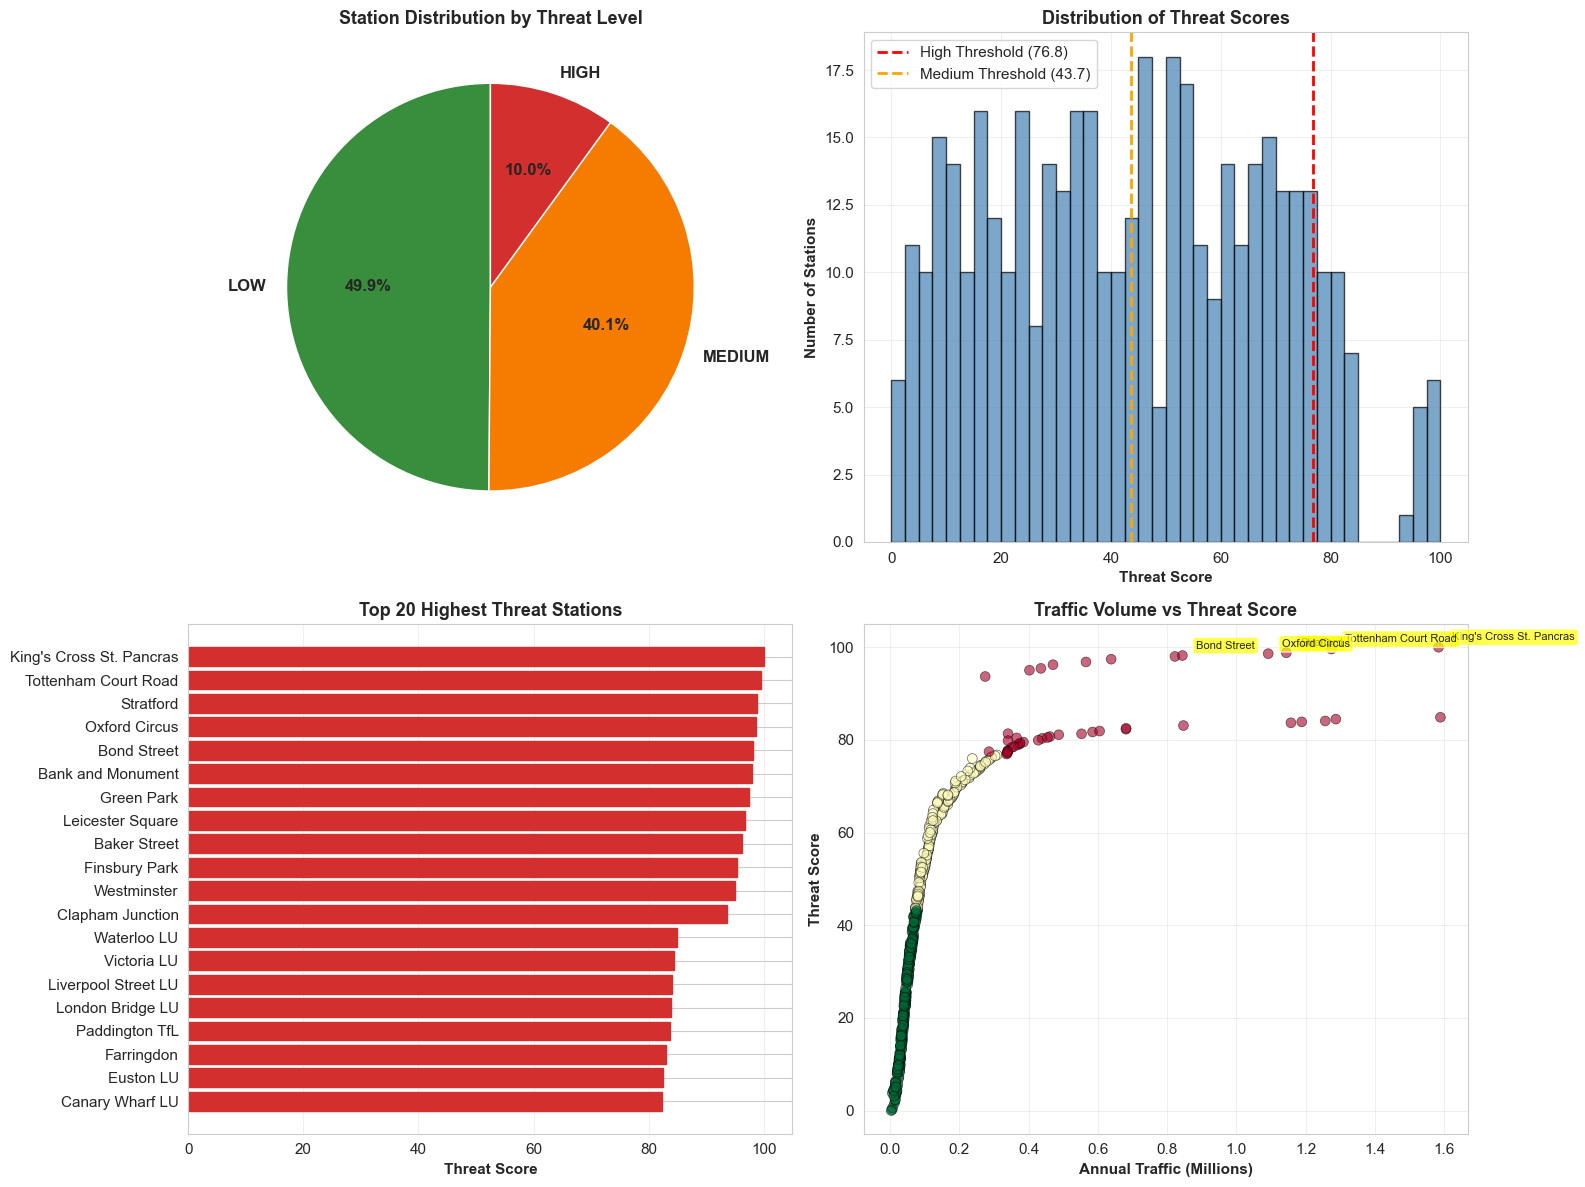

In [12]:
# Create comprehensive threat visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Threat level pie chart
colors_threat = {'HIGH': '#d32f2f', 'MEDIUM': '#f57c00', 'LOW': '#388e3c'}
threat_colors = [colors_threat[level] for level in threat_counts.index]
axes[0, 0].pie(threat_counts.values, labels=threat_counts.index, autopct='%1.1f%%',
               colors=threat_colors, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0, 0].set_title('Station Distribution by Threat Level', fontsize=13, fontweight='bold')

# 2. Threat score histogram with classifications
axes[0, 1].hist(df_stations['Threat_Score_Normalized'], bins=40, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(threshold_high, color='red', linestyle='--', linewidth=2, label=f'High Threshold ({threshold_high:.1f})')
axes[0, 1].axvline(threshold_medium, color='orange', linestyle='--', linewidth=2, label=f'Medium Threshold ({threshold_medium:.1f})')
axes[0, 1].set_xlabel('Threat Score', fontweight='bold')
axes[0, 1].set_ylabel('Number of Stations', fontweight='bold')
axes[0, 1].set_title('Distribution of Threat Scores', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Top 20 stations by threat score
top_20_threat = df_stations.nlargest(20, 'Threat_Score_Normalized')
bars = axes[1, 0].barh(range(len(top_20_threat)), top_20_threat['Threat_Score_Normalized'].values)
axes[1, 0].set_yticks(range(len(top_20_threat)))
axes[1, 0].set_yticklabels(top_20_threat['Station_Name'].values)
axes[1, 0].set_xlabel('Threat Score', fontweight='bold')
axes[1, 0].set_title('Top 20 Highest Threat Stations', fontsize=13, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# Color bars by threat level
for bar, threat_level in zip(bars, top_20_threat['Threat_Level'].values):
    bar.set_color(colors_threat[threat_level])

# 4. Scatter: Traffic vs Threat Score
scatter = axes[1, 1].scatter(df_stations['Annual_EntryExit'] / 1e6, 
                             df_stations['Threat_Score_Normalized'],
                             c=df_stations['Threat_Level'].map({'HIGH': 2, 'MEDIUM': 1, 'LOW': 0}),
                             cmap='RdYlGn_r', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1, 1].set_xlabel('Annual Traffic (Millions)', fontweight='bold')
axes[1, 1].set_ylabel('Threat Score', fontweight='bold')
axes[1, 1].set_title('Traffic Volume vs Threat Score', fontsize=13, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# Add annotations for top 5 stations
for i, row in df_stations.nlargest(5, 'Threat_Score_Normalized').iterrows():
    axes[1, 1].annotate(row['Station_Name'], 
                        xy=(row['Annual_EntryExit']/1e6, row['Threat_Score_Normalized']),
                        xytext=(10, 5), textcoords='offset points', fontsize=8,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

## 8. Analyze Threat Patterns by Transport Mode

In [13]:
# Average threat score by mode
mode_threat = df_stations.groupby('Mode').agg({
    'Threat_Score_Normalized': ['mean', 'max', 'count'],
    'Annual_EntryExit': 'sum'
}).round(2)

mode_threat.columns = ['Avg_Threat_Score', 'Max_Threat_Score', 'Station_Count', 'Total_Traffic']
mode_threat = mode_threat.sort_values('Avg_Threat_Score', ascending=False)

print("Threat Analysis by Transport Mode:")
print("="*80)
print(mode_threat)
print("="*80)

Threat Analysis by Transport Mode:
      Avg_Threat_Score  Max_Threat_Score  Station_Count  Total_Traffic
Mode                                                                  
EZL              49.97             80.44             33     4017436.59
LU               48.89            100.00            267    49204139.39
DLR              36.18             75.99             41     2825282.95
LO               30.69             93.69             88     5226795.59


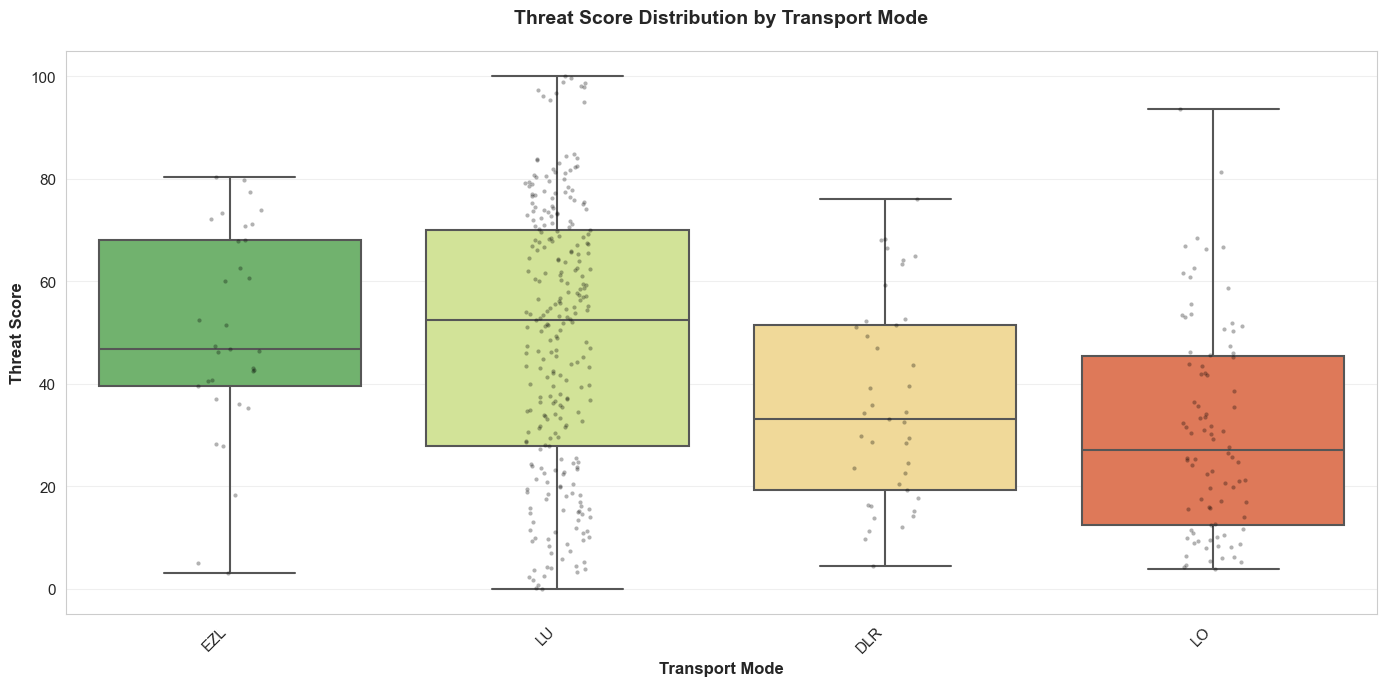

In [14]:
# Box plot of threat scores by mode
plt.figure(figsize=(14, 7))

modes_ordered = df_stations.groupby('Mode')['Threat_Score_Normalized'].mean().sort_values(ascending=False).index
df_stations_sorted = df_stations.copy()
df_stations_sorted['Mode'] = pd.Categorical(df_stations_sorted['Mode'], categories=modes_ordered, ordered=True)

sns.boxplot(data=df_stations_sorted, x='Mode', y='Threat_Score_Normalized', 
            palette='RdYlGn_r', linewidth=1.5)
sns.stripplot(data=df_stations_sorted, x='Mode', y='Threat_Score_Normalized', 
              color='black', alpha=0.3, size=3)

plt.xlabel('Transport Mode', fontsize=12, fontweight='bold')
plt.ylabel('Threat Score', fontsize=12, fontweight='bold')
plt.title('Threat Score Distribution by Transport Mode', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Export Threat Assessment Data

Save the complete threat assessment for use in website visualization.

In [15]:
# Prepare export dataset
df_export = df_stations[[
    'Station_Code', 'Station_Name', 'Mode', 'Annual_EntryExit',
    'Crowd_Density_Score', 'Infrastructure_Score', 'Vulnerability_Score',
    'Threat_Score_Normalized', 'Threat_Level', 'Is_Major_Hub'
]].copy()

df_export.columns = [
    'station_code', 'station_name', 'mode', 'annual_traffic',
    'crowd_density_score', 'infrastructure_score', 'vulnerability_score',
    'threat_score', 'threat_level', 'is_major_hub'
]

# Sort by threat score
df_export = df_export.sort_values('threat_score', ascending=False)

# Save to CSV
output_path = Path('../data') / 'tfl_threat_assessment.csv'
df_export.to_csv(output_path, index=False)

print(f"✓ Threat assessment data exported to: {output_path}")
print(f"✓ Total stations: {len(df_export)}")
print(f"✓ Columns: {', '.join(df_export.columns)}")

✓ Threat assessment data exported to: ../data/tfl_threat_assessment.csv
✓ Total stations: 429
✓ Columns: station_code, station_name, mode, annual_traffic, crowd_density_score, infrastructure_score, vulnerability_score, threat_score, threat_level, is_major_hub


## 10. Summary and Key Findings

In [16]:
print("="*100)
print("THREAT SCORING ANALYSIS - EXECUTIVE SUMMARY")
print("="*100)

print("\n1. METHODOLOGY")
print("   Composite threat score calculated from:")
print("   • Crowd Density (50%): Based on annual passenger traffic")
print("   • Infrastructure Criticality (30%): Major hubs and symbolic targets")
print("   • Vulnerability (20%): Accessibility and security control levels")

print("\n2. CLASSIFICATION RESULTS")
print(f"   • HIGH THREAT:   {threat_counts.get('HIGH', 0):3d} stations (≥90th percentile) - PRIORITY MONITORING")
print(f"   • MEDIUM THREAT: {threat_counts.get('MEDIUM', 0):3d} stations (50th-90th percentile) - ENHANCED AWARENESS")
print(f"   • LOW THREAT:    {threat_counts.get('LOW', 0):3d} stations (<50th percentile) - ROUTINE SECURITY")

print("\n3. HIGHEST RISK STATIONS (Top 10)")
for idx, (i, row) in enumerate(df_stations.nlargest(10, 'Threat_Score_Normalized').iterrows(), 1):
    print(f"   {idx:2d}. {row['Station_Name']:<30} Score: {row['Threat_Score_Normalized']:5.1f} | Traffic: {row['Annual_EntryExit']/1e6:5.1f}M | Hub: {'Yes' if row['Is_Major_Hub'] else 'No'}")

print("\n4. RISK PATTERNS")
lu_avg = df_stations[df_stations['Mode'] == 'LU']['Threat_Score_Normalized'].mean()
print(f"   • London Underground average threat score: {lu_avg:.1f}")
print(f"   • Major hubs average threat score: {df_stations[df_stations['Is_Major_Hub']==1]['Threat_Score_Normalized'].mean():.1f}")
print(f"   • Non-hub average threat score: {df_stations[df_stations['Is_Major_Hub']==0]['Threat_Score_Normalized'].mean():.1f}")
print(f"   • Hub threat elevation: {(df_stations[df_stations['Is_Major_Hub']==1]['Threat_Score_Normalized'].mean() / df_stations[df_stations['Is_Major_Hub']==0]['Threat_Score_Normalized'].mean() - 1)*100:.1f}%")

print("\n5. ACTIONABLE INSIGHTS")
print("   ⚠️  HIGH THREAT stations require:")
print("      - Enhanced surveillance and security presence")
print("      - Regular security drills and emergency preparedness")
print("      - Real-time monitoring integration")
print("      - Structural vulnerability assessments")
print("   ")
print("   ⚠️  Major interchange hubs show elevated risk due to:")
print("      - High symbolic value as critical infrastructure")
print("      - Dense crowd concentrations")
print("      - Multiple access points and complexity")
print("      - Network disruption potential")

print("\n6. DATA QUALITY NOTES")
print("   • Analysis based on 2024 annualized TfL data")
print("   • Threat scoring uses evidence-based weighting")
print("   • Does NOT include: historical incident data, live events, current threat intelligence")
print("   • Recommended: Integrate with Stage 2 live threat detection")

print("\n" + "="*100)
print("NEXT STEPS: Integrate with geospatial visualization for interactive threat mapping")
print("="*100)

THREAT SCORING ANALYSIS - EXECUTIVE SUMMARY

1. METHODOLOGY
   Composite threat score calculated from:
   • Crowd Density (50%): Based on annual passenger traffic
   • Infrastructure Criticality (30%): Major hubs and symbolic targets
   • Vulnerability (20%): Accessibility and security control levels

2. CLASSIFICATION RESULTS
   • HIGH THREAT:    43 stations (≥90th percentile) - PRIORITY MONITORING
   • MEDIUM THREAT: 172 stations (50th-90th percentile) - ENHANCED AWARENESS
   • LOW THREAT:    214 stations (<50th percentile) - ROUTINE SECURITY

3. HIGHEST RISK STATIONS (Top 10)
    1. King's Cross St. Pancras       Score: 100.0 | Traffic:   1.6M | Hub: Yes
    2. Tottenham Court Road           Score:  99.6 | Traffic:   1.3M | Hub: Yes
    3. Stratford                      Score:  98.8 | Traffic:   1.1M | Hub: Yes
    4. Oxford Circus                  Score:  98.6 | Traffic:   1.1M | Hub: Yes
    5. Bond Street                    Score:  98.2 | Traffic:   0.8M | Hub: Yes
    6. Bank an

## 11. Recommendations for Website Integration

This threat assessment provides the **static risk layer** for the PERIL website:

### Map Visualization
- Display stations color-coded by threat level:
  - **Red (HIGH)**: Immediate attention, enhanced security protocols
  - **Orange (MEDIUM)**: Elevated awareness, standard security
  - **Green (LOW)**: Routine monitoring

### Interactive Features
- Click on station to view detailed risk breakdown:
  - Annual traffic volume
  - Threat score components (crowd density, criticality, vulnerability)
  - Infrastructure classification (hub status)
  - Recommended security measures

### Integration with Live Data (Stage 2)
- Overlay scheduled events near high-threat stations
- Highlight stations with disruptions or incidents
- Dynamic risk elevation based on real-time factors
- Alert system for concurrent high-threat conditions

### Data Updates
- Refresh static scores quarterly with new TfL data
- Continuously ingest live threat indicators
- Maintain historical trends for pattern analysis

The next notebook will provide specific implementation recommendations for the web platform.